# Inference: Attention Map and Dice Score Metric Evaluation

In [1]:
import os
import glob
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from rad_dino.data.preprocessing import *
from rad_dino.utils.dice_score import *

In [3]:
def list_attention_image_ids(attn_root: str) -> List[str]:
    """
    Scan attn_root and return all image_ids
    for which there exists an 'attention_{image_id}' folder.
    """
    subdirs = os.listdir(attn_root)
    image_ids = []
    for name in subdirs:
        path = os.path.join(attn_root, name)
        if not os.path.isdir(path):
            continue
        if not name.startswith("attention_"):
            continue
        # name is like "attention_00322d4d-1c29-4943-afc9-b6754be640eb"
        image_id = name.split("attention_", 1)[1]
        image_ids.append(image_id)
    return image_ids

def compute_average_dice_score(image_ids, 
                               df_annot, 
                               attention_map_folder, 
                               raw_img_foler,
                               dataset_name,
                               attention_threshold=0.5,
                               attention_map_method="raw",
                               attention_fusion_method="mean"):
    """
    Compute average dice scores among images in test dataset.
    
    Args:
        image_ids: List of image identifiers.
        df_annot: DataFrame containing annotations.
        attention_map_folder: Folder containing attention maps.
        dataset_name: Name of the dataset.
        attention_threshold: Threshold for binarizing attention map. By default, 0.5.
        attention_map_method: ["raw", "rollout", "lrp"]
        attention_fusion_method: ["mean", "min", "max"]        
        
    Returns:
        mean_dice_score: average dice score among test set.
        dice_scores: dictionary mapping image_id to dice score.
    """
    dice_scores = {}
    for i, image_id in enumerate(image_ids):
        display_attn_map = True if i == 0 else False
        display_bm = True if i == 0 else False
        dice_score = compute_dice_score_per_image(
            image_id=image_id, 
            df_annot=df_annot, 
            attn_map_folder=attention_map_folder, 
            image_root_folder=raw_img_foler,
            dataset_name=dataset_name,
            attention_threshold=attention_threshold,
            attn_map_method=attention_map_method,       
            attn_fusion_method=attention_fusion_method,    
            display_attn_map=display_attn_map,
            display_binary_mask=display_bm
        )
        dice_scores[image_id] = dice_score
    valid_scores = [score for score in dice_scores.values() if score is not None]
    if not valid_scores:
        return 0.0
    mean_dice_score = np.mean(valid_scores)
    return mean_dice_score, dice_scores

## RSNA-Pneumonia
### 1. Raw attention map
#### 1.1 Mean-fusion

In [4]:
dataset_name = "RSNA-Pneumonia"
raw_root_folder = f"/hpcwork/rwth1833/datasets/{dataset_name}"
attn_root_folder = f"/hpcwork/rwth1833/experiments/{dataset_name}/checkpoints_2025_06_02_232714_RSNA-Pneumonia_dinov2-small_unfreeze_backbone/attention"
raw_img_filepath = glob.glob(os.path.join(raw_root_folder, "stage_2_train_images", '*.dcm'))
df_annot = pd.read_csv(os.path.join(raw_root_folder, "stage_2_train_labels.csv"))
positive_image_id_list = df_annot[df_annot['Target'] == 1]['patientId'].values.tolist()
test_data_image_id_list = list_attention_image_ids(attn_root_folder)
image_ids = list(set(test_data_image_id_list).intersection(positive_image_id_list))

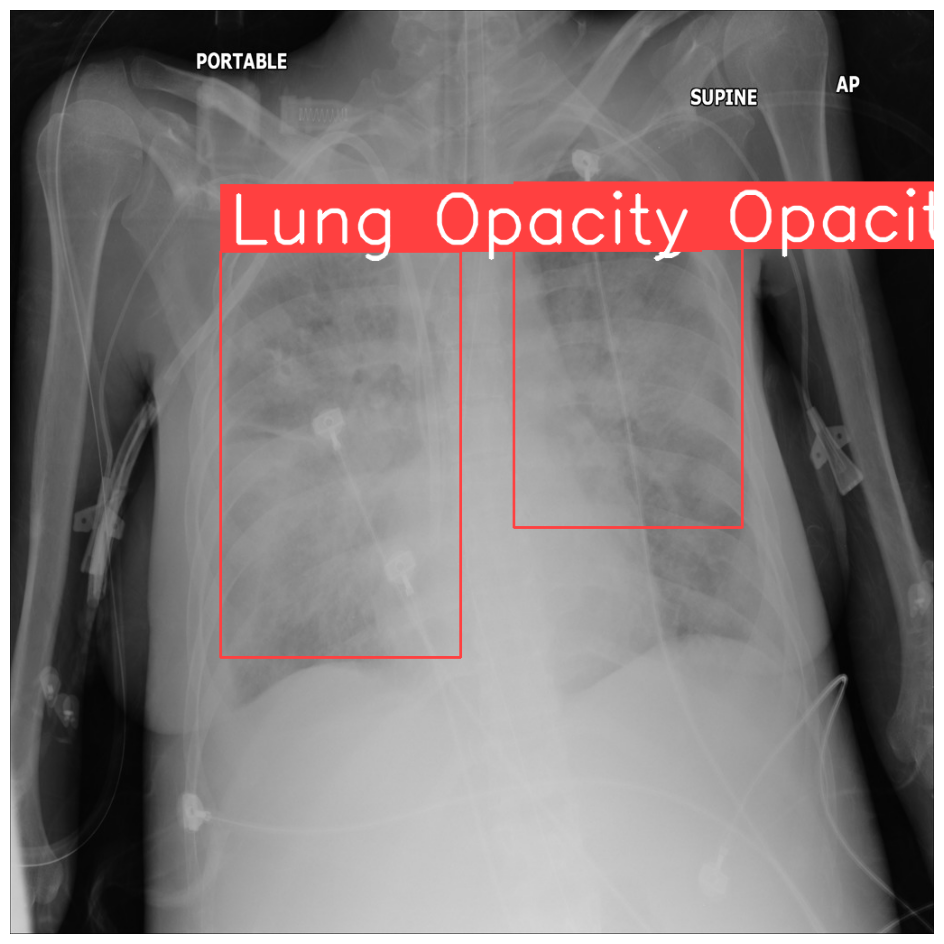

In [5]:
plot_annotated_bbox(image_id=image_ids[0], 
                    root_folder=raw_root_folder,
                    df_annot=df_annot,
                    dataset_name=dataset_name)

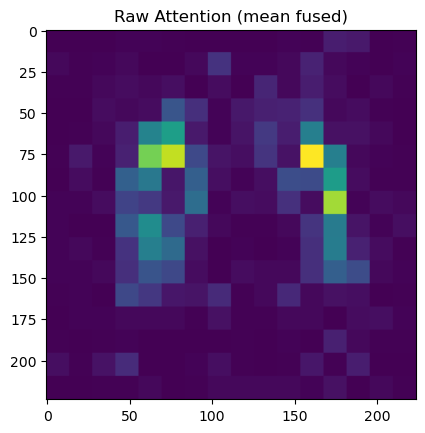

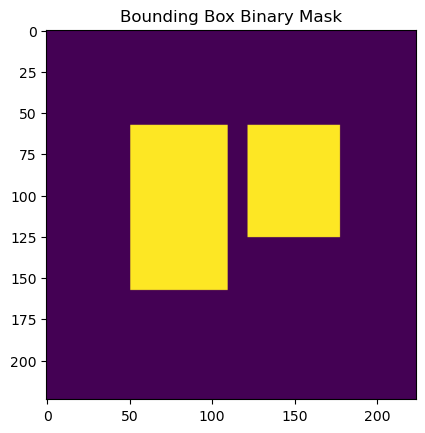

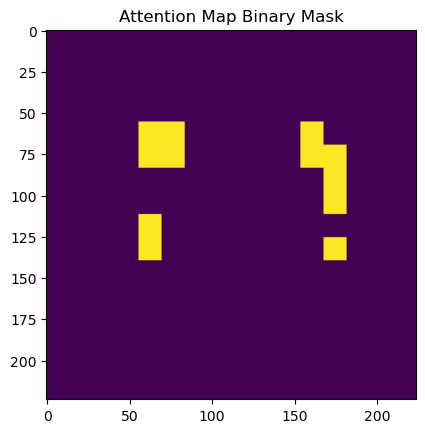

In [6]:
mean_dice_score, dice_score_results = compute_average_dice_score(image_ids,
                                                                 df_annot,
                                                                 attn_root_folder,
                                                                 raw_root_folder,
                                                                 dataset_name,
                                                                 attention_threshold=0.5
                                                                 )

In [7]:
df_dice = pd.DataFrame([
    {"image_id": img_id, "dice": dice}
    for img_id, dice in dice_score_results.items()
])
print(df_dice.describe())
print(f"Mean dice score for mean-fusion raw attention map: {mean_dice_score:.3f}")
dice_score_folder = f"/hpcwork/rwth1833/experiments/{dataset_name}/checkpoints_2025_06_02_232714_RSNA-Pneumonia_dinov2-small_unfreeze_backbone/dice_score"
if not os.path.exists(dice_score_folder):
    os.mkdir(dice_score_folder)
df_dice.to_csv(os.path.join(dice_score_folder, "dice_scores_raw_attn_mean_fused.csv"), index=False)

              dice
count  1202.000000
mean      0.233543
std       0.142187
min       0.000000
25%       0.127519
50%       0.208694
75%       0.322154
max       0.811159
Mean dice score for mean-fusion raw attention map: 0.234


#### 1.2 Min-fusion

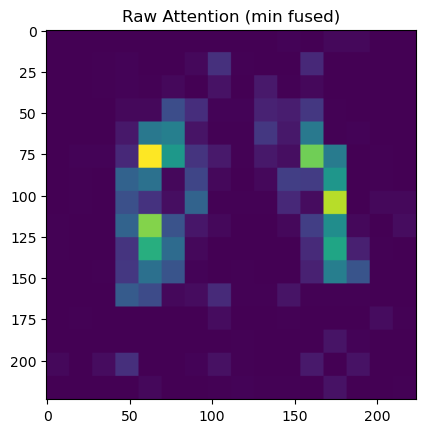

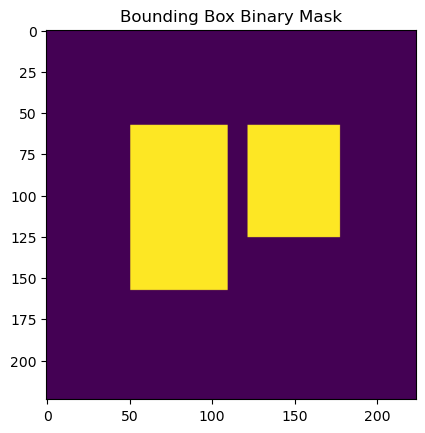

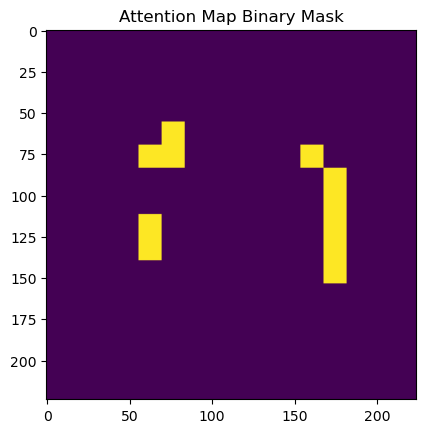

In [8]:
mean_dice_score, dice_score_results = compute_average_dice_score(image_ids,
                                                                 df_annot,
                                                                 attn_root_folder,
                                                                 raw_root_folder,
                                                                 dataset_name,
                                                                 attention_threshold=0.5,
                                                                 attention_fusion_method="min"
                                                                 )

In [9]:
df_dice = pd.DataFrame([
    {"image_id": img_id, "dice": dice}
    for img_id, dice in dice_score_results.items()
])
print(df_dice.describe())
print(f"Mean dice score for min-fusion raw attention map: {mean_dice_score:.3f}")
dice_score_folder = f"/hpcwork/rwth1833/experiments/{dataset_name}/checkpoints_2025_06_02_232714_RSNA-Pneumonia_dinov2-small_unfreeze_backbone/dice_score"
if not os.path.exists(dice_score_folder):
    os.mkdir(dice_score_folder)
df_dice.to_csv(os.path.join(dice_score_folder, "dice_scores_raw_attn_min_fused.csv"), index=False)

              dice
count  1202.000000
mean      0.218700
std       0.138375
min       0.000000
25%       0.119036
50%       0.200034
75%       0.296559
max       0.811159
Mean dice score for min-fusion raw attention map: 0.219


#### 1.3 Max-fusion

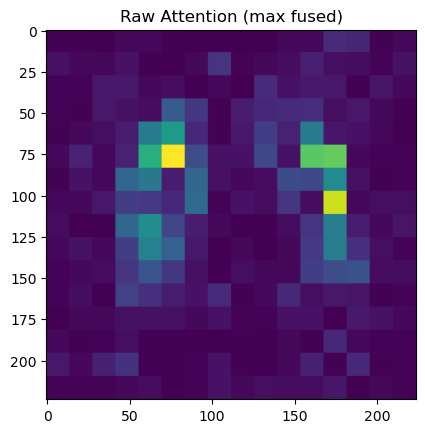

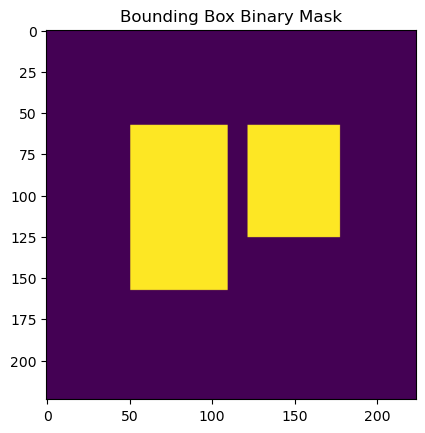

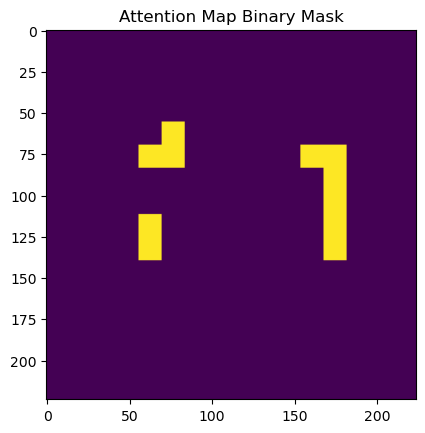

In [10]:
mean_dice_score, dice_score_results = compute_average_dice_score(image_ids,
                                                                 df_annot,
                                                                 attn_root_folder,
                                                                 raw_root_folder,
                                                                 dataset_name,
                                                                 attention_threshold=0.5,
                                                                 attention_fusion_method="max"
                                                                 )

In [11]:
df_dice = pd.DataFrame([
    {"image_id": img_id, "dice": dice}
    for img_id, dice in dice_score_results.items()
])
print(df_dice.describe())
print(f"Mean dice score for max-fusion raw attention map: {mean_dice_score:.3f}")
dice_score_folder = f"/hpcwork/rwth1833/experiments/{dataset_name}/checkpoints_2025_06_02_232714_RSNA-Pneumonia_dinov2-small_unfreeze_backbone/dice_score"
if not os.path.exists(dice_score_folder):
    os.mkdir(dice_score_folder)
df_dice.to_csv(os.path.join(dice_score_folder, "dice_scores_raw_attn_max_fused.csv"), index=False)

              dice
count  1202.000000
mean      0.236849
std       0.141124
min       0.000000
25%       0.134009
50%       0.215385
75%       0.317857
max       0.811159
Mean dice score for max-fusion raw attention map: 0.237


### 2. Attention Rollout

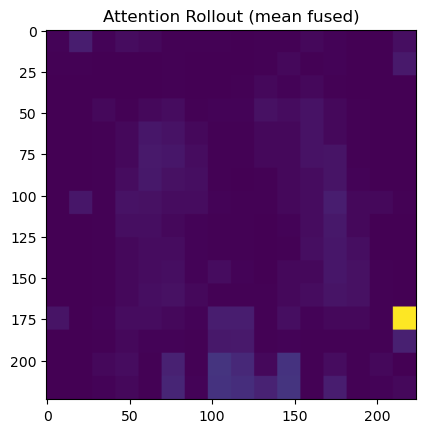

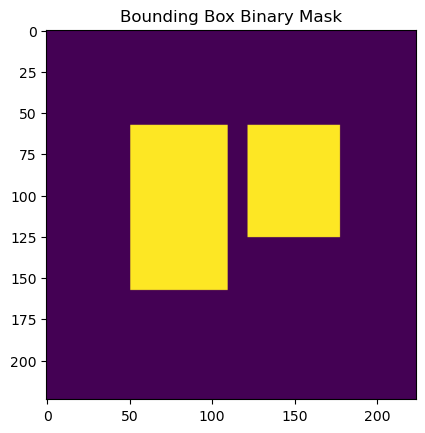

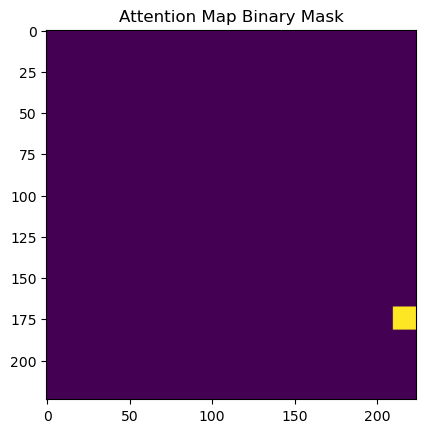

In [12]:
mean_dice_score, dice_score_results = compute_average_dice_score(image_ids,
                                                                 df_annot,
                                                                 attn_root_folder,
                                                                 raw_root_folder,
                                                                 dataset_name,
                                                                 attention_threshold=0.5,
                                                                 attention_fusion_method="mean",
                                                                 attention_map_method="rollout"
                                                                 )

In [13]:
df_dice = pd.DataFrame([
    {"image_id": img_id, "dice": dice}
    for img_id, dice in dice_score_results.items()
])
print(df_dice.describe())
print(f"Mean dice score for mean-fusion attention rollout: {mean_dice_score:.3f}")
dice_score_folder = f"/hpcwork/rwth1833/experiments/{dataset_name}/checkpoints_2025_06_02_232714_RSNA-Pneumonia_dinov2-small_unfreeze_backbone/dice_score"
if not os.path.exists(dice_score_folder):
    os.mkdir(dice_score_folder)
df_dice.to_csv(os.path.join(dice_score_folder, "dice_scores_attn_rollout_mean_fused.csv"), index=False)

              dice
count  1202.000000
mean      0.007127
std       0.029035
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.432000
Mean dice score for mean-fusion attention rollout: 0.007


#### 2.2 Min-fusion

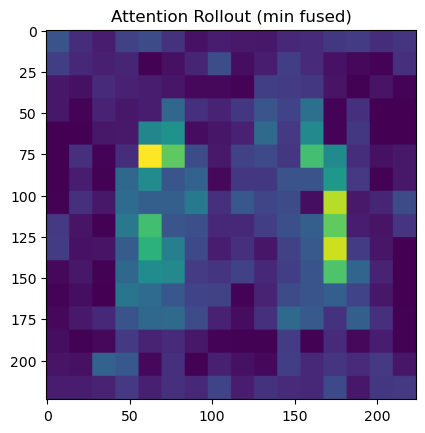

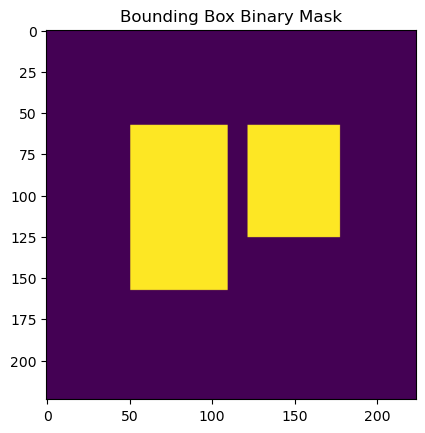

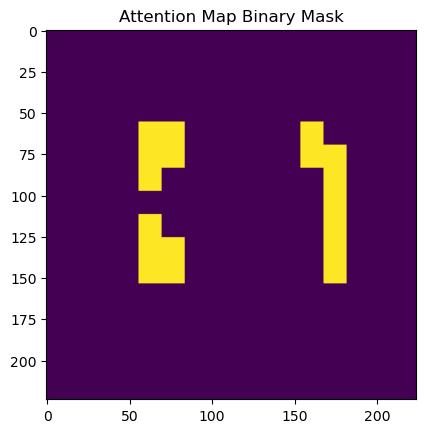

In [14]:
mean_dice_score, dice_score_results = compute_average_dice_score(image_ids,
                                                                 df_annot,
                                                                 attn_root_folder,
                                                                 raw_root_folder,
                                                                 dataset_name,
                                                                 attention_threshold=0.5,
                                                                 attention_fusion_method="min",
                                                                 attention_map_method="rollout"
                                                                 )

In [15]:
df_dice = pd.DataFrame([
    {"image_id": img_id, "dice": dice}
    for img_id, dice in dice_score_results.items()
])
print(df_dice.describe())
print(f"Mean dice score for min-fusion attention rollout: {mean_dice_score:.3f}")
dice_score_folder = f"/hpcwork/rwth1833/experiments/{dataset_name}/checkpoints_2025_06_02_232714_RSNA-Pneumonia_dinov2-small_unfreeze_backbone/dice_score"
if not os.path.exists(dice_score_folder):
    os.mkdir(dice_score_folder)
df_dice.to_csv(os.path.join(dice_score_folder, "dice_scores_attn_rollout_min_fused.csv"), index=False)

              dice
count  1202.000000
mean      0.327819
std       0.149487
min       0.000000
25%       0.220166
50%       0.326864
75%       0.432095
max       0.755299
Mean dice score for min-fusion attention rollout: 0.328


#### 2.3 Max-fusion

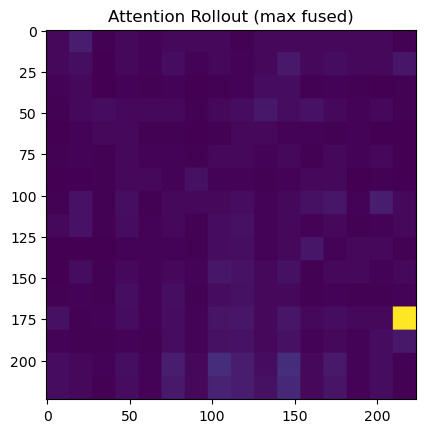

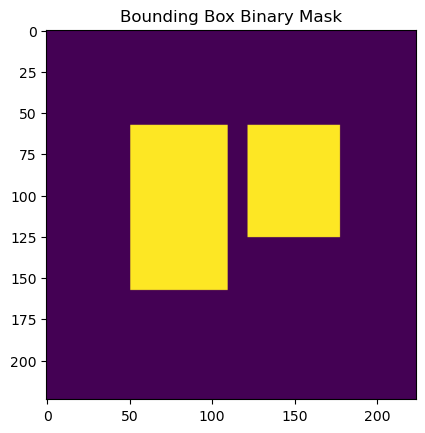

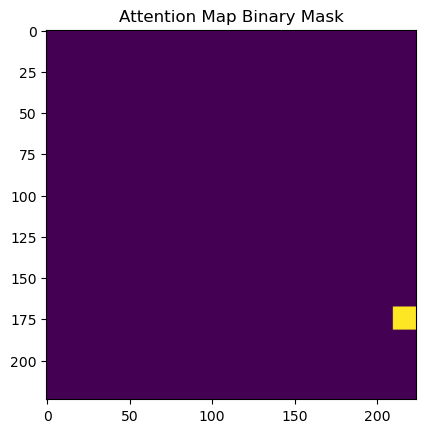

In [16]:
mean_dice_score, dice_score_results = compute_average_dice_score(image_ids,
                                                                 df_annot,
                                                                 attn_root_folder,
                                                                 raw_root_folder,
                                                                 dataset_name,
                                                                 attention_threshold=0.5,
                                                                 attention_fusion_method="max",
                                                                 attention_map_method="rollout"
                                                                 )

In [17]:
df_dice = pd.DataFrame([
    {"image_id": img_id, "dice": dice}
    for img_id, dice in dice_score_results.items()
])
print(df_dice.describe())
print(f"Mean dice score for max-fusion attention rollout: {mean_dice_score:.3f}")
dice_score_folder = f"/hpcwork/rwth1833/experiments/{dataset_name}/checkpoints_2025_06_02_232714_RSNA-Pneumonia_dinov2-small_unfreeze_backbone/dice_score"
if not os.path.exists(dice_score_folder):
    os.mkdir(dice_score_folder)
df_dice.to_csv(os.path.join(dice_score_folder, "dice_scores_attn_rollout_max_fused.csv"), index=False)

              dice
count  1202.000000
mean      0.003028
std       0.016734
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.258575
Mean dice score for max-fusion attention rollout: 0.003


#### Visualize in boxplot

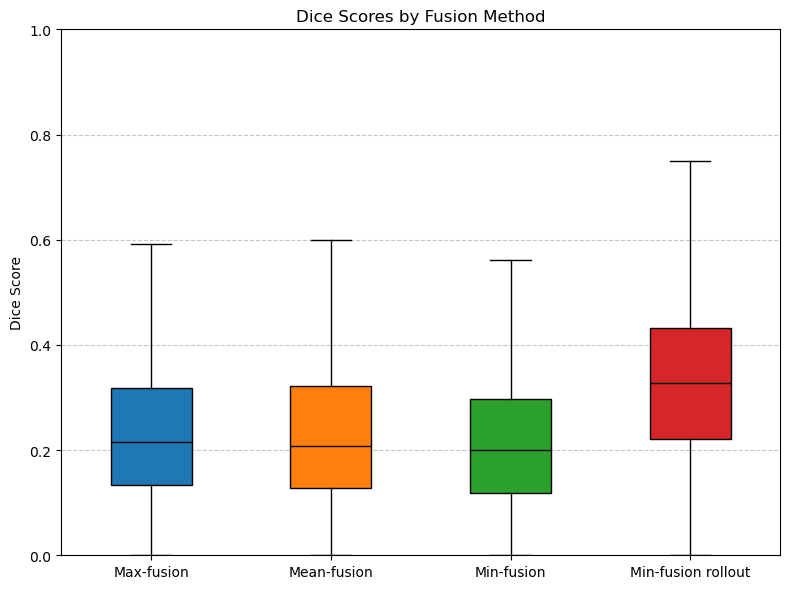

In [18]:
files = {
    'Max-fusion':  os.path.join(dice_score_folder, 'dice_scores_raw_attn_max_fused.csv'),
    'Mean-fusion': os.path.join(dice_score_folder, 'dice_scores_raw_attn_mean_fused.csv'),
    'Min-fusion':  os.path.join(dice_score_folder, 'dice_scores_raw_attn_min_fused.csv'),
    'Min-fusion rollout': os.path.join(dice_score_folder, 'dice_scores_attn_rollout_min_fused.csv')
}
# Read each CSV into a list of Dice‐score arrays
data = []
labels = []
for label, fname in files.items():
    df = pd.read_csv(fname)
    if 'dice' not in df.columns:
        raise KeyError(f"Expected a 'dice' column in {fname}")
    data.append(df['dice'].values)
    labels.append(label)
    
# Plot
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
fig, ax = plt.subplots(figsize=(8,6))
box = ax.boxplot(
    data,
    labels=labels,
    patch_artist=True,       # allow box filling
    showfliers=False,        # hide outliers if you like
    medianprops=dict(color='black')
)
# Color each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
ax.set_title("Dice Scores by Fusion Method")
ax.set_ylabel("Dice Score")
ax.set_ylim(0, 1)  # since dice ranges [0,1]
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()